In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sys
import json
from numpy import linalg as LA
import tensorflow as tf
from sklearn.decomposition import PCA

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from analysis import clustering, standard_analysis, variance
import numpy.random as npr
from tools_lnd import make_h_all, PC_axes, get_T_inds, make_dendro

In [2]:
figpath = os.path.join(p,'code','overleaf','multitask-nets','v4_figs','paper_figs','fig4','lesion_effects')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [3]:
##################################################################
#Find right model dir
##################################################################

rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
          'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
          'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

# rule_trains = ['fdgo', 'delaygo', 'fdanti']

rule_trains_str = '_'.join(rule_trains)

# parse input arguments as:
rnn_type = 'LeakyRNN'
activation = 'softplus'
w_init = 'diag'
ruleset = 'all'
n_tasks = str(len(rule_trains))
n_rnn = str(256)
l2w = float(-6)
l2h = float(-6)
l1w = float(0)
l1h = float(0)
lr = float(-7)
seed = str(0)
net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
data_folder = 'data/rnn/multitask/stepnet/final'

m = os.path.join(p,data_folder,ruleset,rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,seed)

model = FixedPoint_Model(m)
hp = model.hp

Overwrite sigma_rec with 0.000


In [4]:
m = '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1'

/usr/local/Caskroom/miniconda/base/envs/tensorflow/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


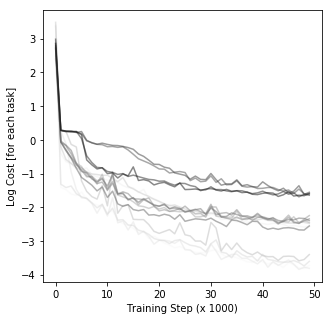

In [5]:
fig = plt.figure(figsize=(5, 5))
cmap=plt.get_cmap('Greys')
fname = os.path.join(m, 'log.json')

task_list = rule_trains

with open(fname, 'r') as f:
    log_all = json.load(f)
for r in range(len(task_list)):
    c = cmap((r+1)/(len(task_list)+1))
    ax = fig.add_subplot(1,1,1)
    x = np.log(log_all['cost_'+task_list[r]])
    plt.plot(x,'-',c = c,alpha = .5)
    ax.set_xlabel('Training Step (x 1000)')
    ax.set_ylabel('Log Cost [for each task]')
#     plt.ylim([-6,2])
    
# plt.title(m)
plt.show()    

In [6]:
m

'/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1'

In [7]:
def make_label_sets(rule_trains):
    label_set = {}
    label_set['anti'] = [('anti' in rule) or ('nogo' in rule) for rule in rule_trains]
    label_set['delay'] = [('delay' in rule) or ('fd' in rule) for rule in rule_trains]
    label_set['dm2'] = ['dm2' in rule for rule in rule_trains]
    label_set['dm1'] = ['dm1' in rule for rule in rule_trains]
    label_set['dmc'] = ['dmc' in rule for rule in rule_trains]
    label_set['react'] = ~np.array(label_set['delay'])

    label_reverse_set = {}
    label_reverse_set['anti'] = ~np.array(label_set['anti'])
    label_reverse_set['delay'] = ~np.array(label_set['delay'])
    label_reverse_set['dm2'] = ['dm1' in rule for rule in rule_trains]
    label_reverse_set['dm1'] = ['dm2' in rule for rule in rule_trains]
    label_reverse_set['dmc'] = ~np.array(label_set['dmc'])
    label_reverse_set['react'] = ~np.array(label_set['react'])
    return label_set, label_reverse_set

In [10]:
# m = '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1'

method = 'ward'
# criterion = 'maxclust'
# max_d = 14
# lesion_folder = 'lesion_fps_hierarchical_'+method+'_'+criterion+'_max_d'+str(max_d)
max_d = 3.5
lesion_folder = 'lesion_fps_hierarchical_'+method+'_max_d'+str(max_d)

# set of networks to compare
rnn_type_set = ['GRU','LeakyRNN']
activation_set = ['softplus','retanh']
w_init_set = ['randgauss','diag']
seed_set = ['0','1','2']
label_set, label_reverse_set = make_label_sets(rule_trains)

frac_true = {}
for motif in label_set.keys():
    frac_true[motif]=np.zeros(24)

fig = plt.figure(figsize=(len(label_set.keys())*3,3),tight_layout=True,facecolor='white')
net_ind = 0

for rnn_type_i in range(len(rnn_type_set)):
    for activation_i in range(len(activation_set)):
        for w_init_i in range(len(w_init_set)):
            
            rnn_type = rnn_type_set[rnn_type_i]
            activation = activation_set[activation_i]
            w_init = w_init_set[w_init_i]

            for seed in seed_set:
                
                net_ind+=1
            
                m = os.path.join(p,data_folder,rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',
                                 net_name,seed)
                save_dir = os.path.join(m,lesion_folder)

                if not os.path.exists(save_dir):
                    os.makedirs(save_dir)
                lesion_var = np.load(os.path.join(save_dir,'lesion_var.npz'))

                perfs_changes = lesion_var['perfs_changes']
                
                for mi in range(len(label_set.keys())):
                    motif = label_set.keys()[mi]

                    in_group = [i for i, x in enumerate(label_set[motif]) if x]
                    out_group = [i for i, x in enumerate(label_reverse_set[motif]) if x]

                    metric = [np.mean(perfs_changes[ci,out_group]) - np.mean(perfs_changes[ci,in_group]) 
                                   for ci in range(len(perfs_changes))]

                    mlm = np.argmax(metric)

                    frac_true[motif][net_ind-1] = np.max(metric)
                    
                    if (metric[mlm]>.5):
                        
                        ax = plt.subplot(1,len(label_set.keys()),mi+1)
                        plt.plot(perfs_changes[mlm,:],'o',alpha = .5)
                        [plt.plot([x, x],[.05, -1],'-k',alpha = .1) for x in in_group]
                        plt.ylim((-1.1,.1))
                        plt.title(motif+' cluster #'+str(mlm+1))

IOError: [Errno 2] No such file or directory: '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/GRU/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/lesion_fps_hierarchical_ward_max_d3.5/lesion_var.npz'

<Figure size 1296x216 with 0 Axes>

In [7]:
method = 'ward'
# criterion = 'maxclust'
# max_d = 14
# lesion_folder = 'lesion_fps_hierarchical_'+method+'_'+criterion+'_max_d'+str(max_d)
max_d = 3.5
lesion_folder = 'lesion_fps_hierarchical_'+method+'_max_d'+str(max_d)

# set of networks to compare
rnn_type_set = ['GRU','LeakyRNN']
activation_set = ['softplus','retanh']
w_init_set = ['randgauss','diag']
seed_set = ['0','1','2']
n_shuff = 1000
label_set, label_reverse_set = make_label_sets(rule_trains)

frac = {}
for motif in label_set.keys():
    frac[motif] = np.zeros((n_shuff,24))

for shuff in range(n_shuff):
    
    label_set, label_reverse_set = make_label_sets(npr.permutation(rule_trains))
    net_ind = 0
    
    for rnn_type_i in range(len(rnn_type_set)):
        for activation_i in range(len(activation_set)):
            for w_init_i in range(len(w_init_set)):

                rnn_type = rnn_type_set[rnn_type_i]
                activation = activation_set[activation_i]
                w_init = w_init_set[w_init_i]

                for seed in seed_set:
                    
                    net_ind += 1

                    m = os.path.join(p,data_folder,rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',
                                     net_name,seed)
                    save_dir = os.path.join(m,lesion_folder)

                    if not os.path.exists(save_dir):
                        os.makedirs(save_dir)
                    lesion_var = np.load(os.path.join(save_dir,'lesion_var.npz'))

                    perfs_changes = lesion_var['perfs_changes']

                    for mi in range(len(label_set.keys())):
                        motif = label_set.keys()[mi]

                        in_group = [i for i, x in enumerate(label_set[motif]) if x]
                        out_group = [i for i, x in enumerate(label_reverse_set[motif]) if x]

                        metric = [np.mean(perfs_changes[ci,out_group]) - np.mean(perfs_changes[ci,in_group]) 
                                       for ci in range(len(perfs_changes))]

                        frac[motif][shuff,net_ind-1] = np.max(metric)

IOError: [Errno 2] No such file or directory: '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/lesion_fps_hierarchical_ward_max_d3.5/lesion_var.npz'

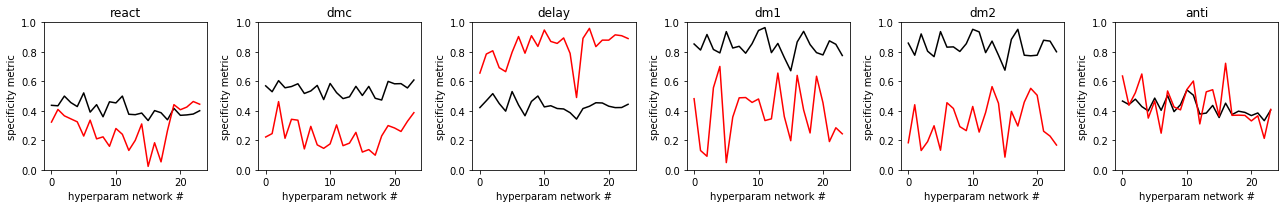

In [16]:
fig = plt.figure(figsize=(len(label_set.keys())*3,3),tight_layout=True,facecolor='white')
plt.subplot(len(label_set.keys()),1,mi+1)
shuff_lim = 950
for mi in range(len(label_set.keys())):
    plt.subplot(1,len(label_set.keys()),mi+1)
    motif = label_set.keys()[mi]
    plt.plot(np.sort(frac[motif],axis = 0)[shuff_lim,:],'k')
    plt.plot(frac_true[motif],'r')
    
    
    plt.title(motif)
    plt.xlabel('hyperparam network #')
    plt.ylabel('specificity metric')
    plt.ylim((0,1))
plt.show()

This figure shows that the delay motif is present in every network we looked at. Specificity index was greater than 95th percentile shuffles for every hyperparameter set. [excluding tanh, not aligned to cell axes]

In [11]:
##################################################################
#Find right model dir
##################################################################

rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
          'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
          'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

# rule_trains = ['fdgo', 'delaygo', 'fdanti']

rule_trains_str = '_'.join(rule_trains)

# parse input arguments as:
rnn_type = 'LeakyRNN'
activation = 'softplus'
w_init = 'diag'
ruleset = 'all'
n_tasks = str(len(rule_trains))
n_rnn = str(256)
l2w = float(-6)
l2h = float(-6)
l1w = float(0)
l1h = float(0)
lr = float(-7)
seed = str(1)
net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
data_folder = 'data/rnn/multitask/stepnet/final'

m = os.path.join(p,data_folder,ruleset,rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,seed)

model = FixedPoint_Model(m)
hp = model.hp

Overwrite sigma_rec with 0.000


In [11]:
m

'/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1'

In [8]:
method = 'ward'
max_d = 3.5
criterion = 'distance'
lesion_folder = 'lesion_fps_hierarchical_'+method+'_max_d'+str(max_d)
# lesion_folder = 'lesion_fps_hierarchical_'+method+'_'+criterion+'_max_d'+str(max_d)
save_dir = os.path.join(m,lesion_folder)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
cluster_var = np.load(os.path.join(save_dir,'cluster_var.npz'))
lesion_var = np.load(os.path.join(save_dir,'lesion_var.npz'))

perfs_changes = lesion_var['perfs_changes']

In [9]:
rules_dict['all']

['fdgo',
 'reactgo',
 'delaygo',
 'fdanti',
 'reactanti',
 'delayanti',
 'delaydm1',
 'delaydm2',
 'contextdelaydm1',
 'contextdelaydm2',
 'multidelaydm',
 'dmsgo',
 'dmsnogo',
 'dmcgo',
 'dmcnogo']

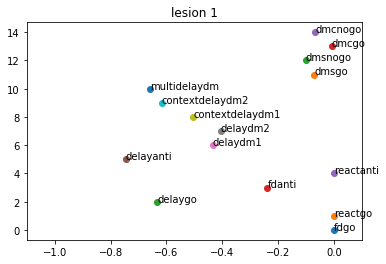

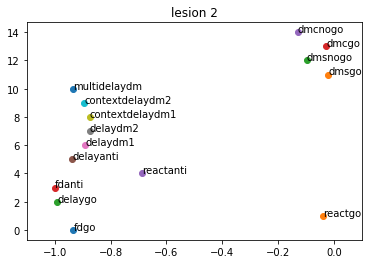

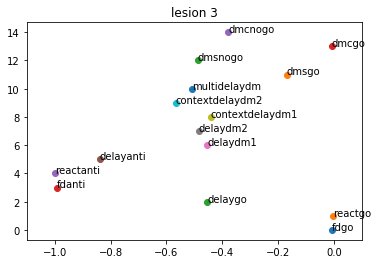

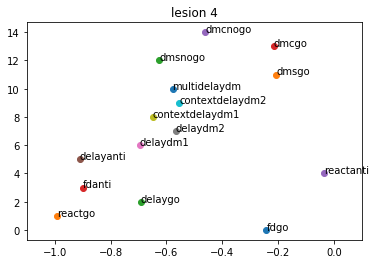

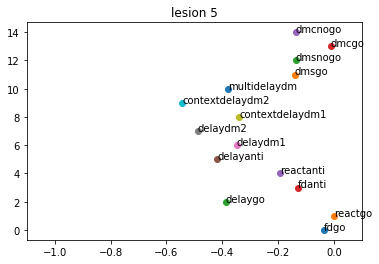

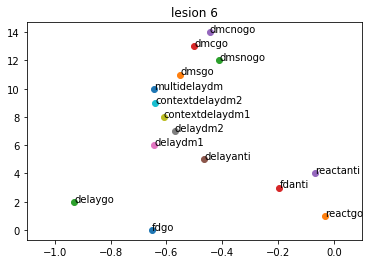

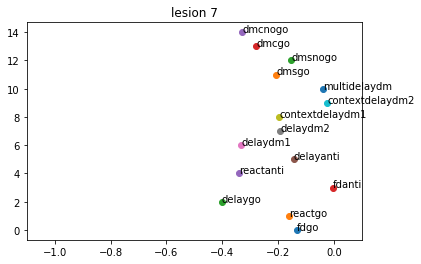

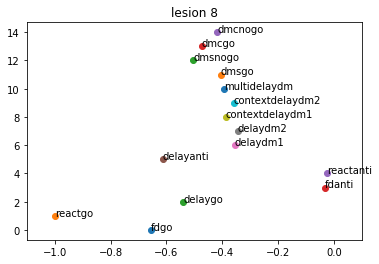

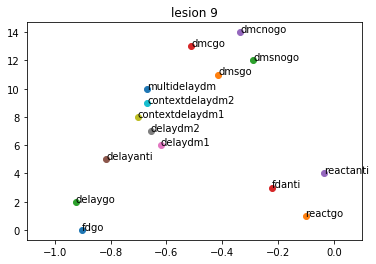

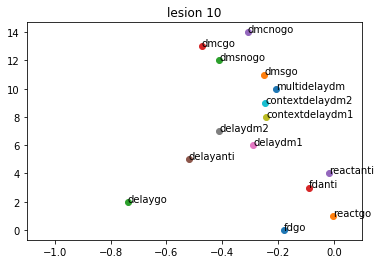

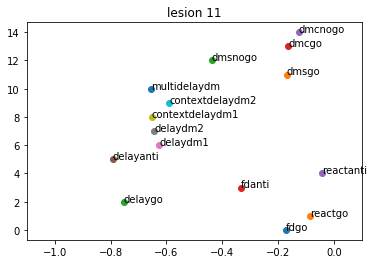

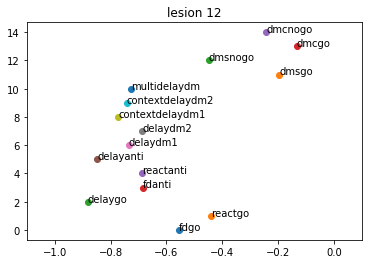

In [10]:
for l in range(len(perfs_changes)):
    for y in range(15):
        plt.text(perfs_changes[l,y],y,rules_dict['all'][y])
        plt.plot(perfs_changes[l,y],y,'o')
    plt.xlim((-1.1,.1))
    plt.title('lesion '+ str(l+1))
    plt.show()

In [12]:
rule_names = {'fdgo':'DelayPro', 
              'reactgo':'ReactPro', 
              'delaygo':'MemoryPro', 
              'fdanti':'DelayAnti', 
              'reactanti':'ReactAnti',
              'delayanti':'MemoryAnti',
              'delaydm1':'DelayD1', 
              'delaydm2':'DelayD2', 
              'contextdelaydm1':'ContextDelayD1', 
              'contextdelaydm2':'ContextDelayD2', 
              'multidelaydm':'MultiDelayD',
              'dmsgo':'DM2SamplePro', 
              'dmsnogo':'DM2SampleAnti', 
              'dmcgo':'DM2CategoryPro', 
              'dmcnogo':'DM2CategoryAnti'}

In [13]:
def make_label_sets(rule_trains):
    label_set = {}
    label_set['Anti'] = [('anti' in rule) or ('nogo' in rule) for rule in rule_trains]
    label_set['Delay'] = [('delay' in rule) or ('fd' in rule) for rule in rule_trains]
    label_set['Modality2'] = ['dm2' in rule for rule in rule_trains]

    label_reverse_set = {}
    label_reverse_set['Anti'] = ~np.array(label_set['Anti'])
    label_reverse_set['Delay'] = ~np.array(label_set['Delay'])
    label_reverse_set['Modality2'] = ['dm1' in rule for rule in rule_trains]
    return label_set, label_reverse_set

In [14]:
label_set,label_reverse_set = make_label_sets(rule_trains)

In [15]:
import matplotlib.patches as mpatches
from scipy.cluster import hierarchy
color_palette = ['b','c', 'm', 'y', 'r']
color_palette = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                 '#e41a1c', '#dede00']
hierarchy.set_link_color_palette(color_palette)
alphabet = {1:'a', 2:'b', 3:'c', 4:'d', 5:'e', 6:'f', 7:'g', 8:'h', 9:'i', 10:'j', 11:'k', 12:'l', 13:'m', 14:'n', 15:'o', 16:'p', 17:'q', 18:'r', 19:'s', 20:'t', 21:'u', 22:'v', 23:'w', 24:'x', 25:'y', 26:'z'}

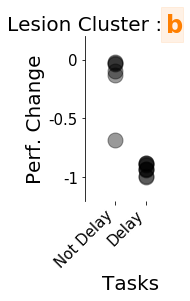

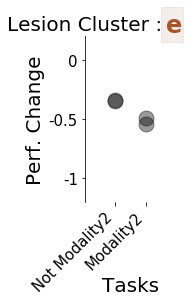

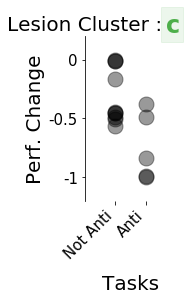

In [22]:
cluster_number = {}
cluster_number['Anti'] = 2
cluster_number['Delay'] = 1
cluster_number['Modality2'] = 4
save_dir = os.path.join(figpath,'lesion_clusters_combined')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
fontsize = 20
tick_fontsize = fontsize*.75
label_fontsize = fontsize*1
plt.rcParams.update({'font.size': fontsize})

for key_i in range(len(label_set.keys())):
    
    fig = plt.figure(figsize=(3,4.5),tight_layout=True,facecolor='white')
    ax = plt.subplot(111)
    
    key = label_set.keys()[key_i]

    perfs_change_cluster = perfs_changes[cluster_number[key],:]

    len_key = np.sum(label_set[key])
    plt.plot(np.ones(len_key),perfs_change_cluster[label_set[key]],
             'ok',markersize = 15,alpha = .4)

    len_key = np.sum(label_reverse_set[key])
    plt.plot(np.zeros(len_key),perfs_change_cluster[label_reverse_set[key]],
             'ok',markersize = 15,alpha = .4)

    plt.ylabel('Perf. Change',fontsize = fontsize)
    ax.set_xticks([0,1])
    ax.set_xticklabels(['Not '+key,key],rotation = 45,ha = 'right',fontsize = tick_fontsize)
    ax.set_yticks([0,-.5,-1])
    ax.set_yticklabels([0,-.5,-1],fontsize = tick_fontsize)
    plt.xlabel('Tasks',fontsize = fontsize)
    ax.xaxis.set_label_coords(.5, -.45)
    plt.title('Lesion Cluster :',fontsize = fontsize, color = 'k',x=0)
    
    #color lesion letter
    text_xloc = 1.5
    text_yloc = .15
    xi = cluster_number[key]+1
    c = color_palette[(xi-1)%len(color_palette)]
    rect=mpatches.Rectangle((text_xloc,text_yloc),.7,.3, 
    fill=True,
    color=c,facecolor=c,alpha = .1,clip_on=False)
    plt.gca().add_patch(rect)
    plt.text(text_xloc*1.1,text_yloc+.08,alphabet[xi],color =c,fontweight='bold',rotation = 0,fontsize = 24)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
#         ax.set_xticks([])
    plt.ylim([-1.2,.2])
    plt.xlim([-1,2])

    figname = 'perf_change_'+key
    plt.savefig(os.path.join(figpath,figname+'.pdf'),bbox_inches='tight')
    plt.savefig(os.path.join(figpath,figname+'.png'),bbox_inches='tight')

In [23]:
h_all_byepoch, h_all_byrule = make_h_all(m,mode = 'test')

Overwrite sigma_rec with 0.000
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


In [24]:
from network import get_perf
from task import generate_trials
from tools_lnd import take_names

fontsize = 20
tick_fontsize = fontsize*.75
label_fontsize = fontsize*1
plt.rcParams.update({'font.size': fontsize})

def plot_lesion(m,task_list,epoch,lesion_units_list,cluster_label = []):

    fig = plt.figure(figsize=(4, 4))
    cmap = plt.get_cmap('hsv')
    c_full = cmap(0.1)
    c_lesion = cmap(.6)
    al = .5
    lw = 6
    
    from tools_lnd import get_model_params
    w_in, b_in, w_out, b_out = get_model_params(m)

    D_out = {}
    D_out['axes'] = w_out[:,1:]
    D_out['labels'] = ['W_{out} cos(theta)','W_{out} sin(theta)']

    model = FixedPoint_Model(m)
    hp = model.hp
    with tf.Session() as sess:
        model.restore()
        model._sigma=0
        if len(lesion_units_list)>0:
            model.lesion_units(sess, lesion_units_list)

        for ri in range(len(task_list)):
            rule = task_list[ri]
            trial = generate_trials(rule, hp, 'test', noise_on = False)
            feed_dict = tools.gen_feed_dict(model, trial, hp)
            h_tf = sess.run(model.h, feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
            
            _components = 3
            pca = PCA(n_components = n_components)
            D_pca = {}
            
            if epoch in trial.epochs.keys():
                T_inds = get_T_inds(trial,epoch) # grab epoch time indexing
            else:
                T_inds = get_T_inds(trial,'go1')
                
            h =  np.transpose(h_all_byrule[rule][T_inds,:,:],(2,1,0))# h_tf[:,range(1,n_trials),:],(2,1,0))
            Xh = np.reshape(h,(h.shape[0],-1))
            fp_pca = pca.fit_transform(Xh.T)
            D_pca['axes'] = pca.components_.T
            D_pca['labels'] = ['PCA '+str(x+1) for x in range(n_components)]

            for trial_i in range(3,np.shape(trial.x)[1],int(np.shape(trial.x)[1]/20)): #includes mod2 trials
                c = cmap(trial.y_loc[-1,trial_i]/(2*np.pi))

#                 ax = plt.subplot(len(task_list),2,1+(2*ri))
                ax = fig.add_axes([0,ri*.6,.3,.3]);
                X_rule = np.dot(h_all_byrule[rule][:,trial_i,:],D_pca['axes'])
                plt.plot(X_rule[:,0],X_rule[:,1],c = c_full,alpha = al,linewidth = lw)
                plt.plot(X_rule[-1,0],X_rule[-1,1],'^',c = c_full,alpha = al,linewidth = lw)

                X_dot = np.dot(h_tf[:,trial_i,:],D_pca['axes'])
                plt.plot(X_dot[:,0],X_dot[:,1],c = c_lesion,alpha = al,linewidth = lw)
                plt.plot(X_dot[-1,0],X_dot[-1,1],'^',c = c_lesion,alpha = al,linewidth = lw)
                
                _, rule_name, _, _ = take_names(epoch,rule)
                plt.title(cluster_label[ri]+r"$\bf{" + rule_name + "}$", y=.98, x = 1)

                plt.xlabel(D_pca['labels'][0])
                plt.ylabel(D_pca['labels'][1])
                ax.spines['right'].set_visible(False)
                ax.spines['top'].set_visible(False) 
                ax.spines['bottom'].set_visible(False)
                ax.spines['left'].set_visible(False)  
                ax.set_xticks([]) 
                ax.set_yticks([])

#                 ax = plt.subplot(len(task_list),2,2+(2*ri))
                ax = fig.add_axes([.5,ri*.6,.3,.3]);
                X_rule = np.dot(h_all_byrule[rule][:,trial_i,:],D_out['axes'])
                plt.plot(X_rule[:,0],X_rule[:,1],c = c_full,alpha = al,linewidth = lw)
                plt.plot(X_rule[-1,0],X_rule[-1,1],'^',c = c_full,alpha = al,linewidth = lw)

                X_dot = np.dot(h_tf[:,trial_i,:],D_out['axes'])
                plt.plot(X_dot[:,0],X_dot[:,1],c = c_lesion,alpha = al,linewidth = lw)
                plt.plot(X_dot[-1,0],X_dot[-1,1],'^',c = c_full,alpha = al,linewidth = lw)

                plt.xlabel('OUT 1')
                plt.ylabel('OUT 2')
                ax.spines['right'].set_visible(False)
                ax.spines['top'].set_visible(False) 
                ax.spines['bottom'].set_visible(False)
                ax.spines['left'].set_visible(False)  
                ax.set_xticks([]) 
                ax.set_yticks([])
                

    figname = 'viz_traj_'+'_'.join(task_list)
    plt.savefig(os.path.join(figpath,figname+'.pdf'),bbox_inches='tight')
    plt.savefig(os.path.join(figpath,figname+'.png'),bbox_inches='tight')

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/mod

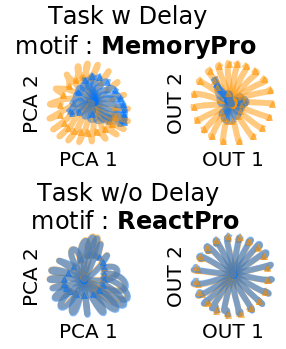

In [25]:
# lesion cluster
n_components = 2
task_list = ['reactgo', 'delaygo']
cluster = cluster_number['Delay']+1
lesion_units_list = cluster_var['lesion_units_list'][cluster]
epoch = 'go1'
plot_lesion(m,task_list,epoch,lesion_units_list,
            cluster_label = ['Task w/o Delay \n motif : ','Task w Delay \n motif : '])

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Overwrite sigma_rec with 0.000
INFO:tensorflow:Restoring parameter

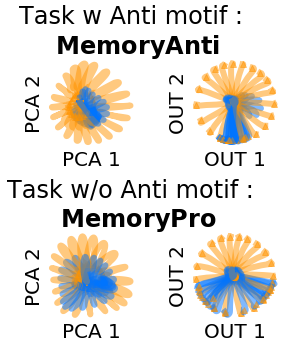

In [26]:
# lesion cluster
task_list = ['delaygo', 'delayanti']
cluster = cluster_number['Anti']+1
lesion_units_list = cluster_var['lesion_units_list'][cluster]
epoch = 'stim1'
plot_lesion(m,task_list,epoch,lesion_units_list,
            cluster_label = ['Task w/o Anti motif : \n ','Task w Anti motif : \n '])

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Overwrite sigma_rec with 0.000
INFO:tensorflow:Restoring parameter

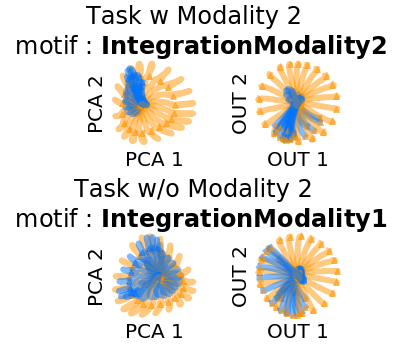

In [27]:
# lesion cluster
task_list = ['delaydm1','delaydm2']
cluster = cluster_number['Modality2']+1
lesion_units_list = cluster_var['lesion_units_list'][cluster]
epoch = 'go1'
plot_lesion(m,task_list,epoch,lesion_units_list,
            cluster_label = ['Task w/o Modality 2 \n motif : ','Task w Modality 2 \n motif : '])

In [28]:
def plot_N3D(ax, X, D, clist, linewidth = 6, alpha = .5, linestyle = '-'):
    """Plot activity is some 2D space.

        Args:
            X: neural activity in Trials x Time x Neurons
            D: Neurons x 2 plotting dims
        """

    cmap=plt.get_cmap('rainbow')
    S = np.shape(X)[0]
    
    for s in range(S):

        if isinstance(clist, str) :
            c = clist
        else:
            c = cmap(clist[s]/max(clist))

        X_trial = np.dot(X[s,:,:],D.T)
#         ax.scatter3D(X_trial[-1,0],X_trial[-1,1],X_trial[-1,2],'^',c = c, linewidth = linewidth, alpha = alpha)
        ax.plot3D(X_trial[:,0],X_trial[:,1],X_trial[:,2],linestyle,c = c, linewidth = linewidth, alpha = alpha)
#         ax.scatter3D(X_trial[0,0],X_trial[0,1],X_trial[0,2],'.',c = c, linewidth = linewidth, alpha = alpha)

In [29]:
def get_filename_fp(trial, epoch,t):
    ind_stim_loc  = str(int(180*trial.y_loc[-1,t]/np.pi))
    nonzero_stim = trial.stim_locs[0,:]<100
    stim_names = '_'.join(str(int(180*x/np.pi)) for x in trial.stim_locs[t,nonzero_stim])
    filename = epoch+'_trial'+str(t)+'_x'+stim_names+'_y'+ind_stim_loc+'.npz'

    return filename, ind_stim_loc

In [30]:
def make_ax_nice(ax, ax_labels, plot_zero_plane = True):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_zticks([])
    epoch_name_ax, rule_name_ax, _, _ = take_names(ax_labels[0],ax_labels[1])
    ax.set_xlabel(r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' PC1', labelpad=-5)
    ax.set_ylabel(r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' PC2', labelpad=-5)
    ax.set_zlabel(r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' PC3', labelpad=-5)
    
    [x1,x2] = ax.get_xlim()
    [y1,y2] = ax.get_ylim()
    ax.set_xlim([x1+.1*x1,x2+.1*x2])
    ax.set_ylim([y1+.1*y1,y2+.1*y2])
    [x1,x2] = ax.get_xlim()
    [y1,y2] = ax.get_ylim()
    
    if plot_zero_plane:
        xx, yy = np.meshgrid(np.linspace(x1, x2, num=2), np.linspace(y1, y2, num=2))
        z = xx*0
        ax.plot_surface(xx, yy, z, alpha=0.1)
        ax.set_zlabel(r"$\bf{Output}$"+r'$\cos{\theta}$',labelpad=-10)
#         ax.text(x1, y1, 0, 'Output Null', (1,0,0))
    elif len(zlabel)>0:
        ax.set_zlabel(zlabel,labelpad=-10)
    ax.set_zlim([-1.1,1.1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([-1,1])

In [31]:
def plot_N3D(ax, X, D, clist, linewidth = 6, alpha = .5, linestyle = '-'):
    """Plot activity is some 2D space.

        Args:
            X: neural activity in Trials x Time x Neurons
            D: Neurons x 2 plotting dims
        """

    cmap=plt.get_cmap('rainbow')
    S = np.shape(X)[0]
    
    for s in range(S):

        if isinstance(clist, str) :
            c = clist
        elif len(clist)==1:
            c = clist[0]
        else:
            c = cmap(clist[s]/max(clist))

        X_trial = np.dot(X[s,:,:],D.T)
        ax.plot3D(X_trial[:,0],X_trial[:,1],X_trial[:,2],linestyle,c = c, linewidth = linewidth, alpha = alpha)

In [32]:
from tools_lnd import get_filename, make_FP_axs, get_model_params
def compare_fp_lesions(m,cluster_var,lesion_cluster,task_list,color_by = 'stim',n_components = 3,fontsize=20):
    
    cmap = plt.get_cmap('hsv')
    c_full = cmap(0.1)
    c_lesion = cmap(.6)
    h_all_byepoch, h_all_byrule = make_h_all(m)
    
    plt.rcParams.update({'font.size': fontsize})
    tick_fontsize = fontsize*.75
    label_fontsize = fontsize*1

    for ri in range(len(task_list)):
        rule = task_list[ri]
        trial = gen_trials_from_model_dir(m,rule,noise_on = False)
        B = np.shape(trial.y_loc)[1]
        N = np.shape(trial.y_loc)[1]
        trial_set = range(0,B,int(B/10))

#         D_pca = {}
#         X_rule = h_all_byrule[rule]
#         X_flat = np.reshape(X_rule,(-1,np.shape(h_all_byrule['fdgo'])[2]))

#         pca = PCA(n_components = n_components)
#         fp_pca = pca.fit_transform(X_flat)
#         D_pca['axes'] = pca.components_.T
#         D_pca['labels'] = ['pca_'+str(x+1) for x in range(n_components)]

#         D_use = D_pca['axes']
#         axes_labels = D_pca['labels']
        
        
        rule_set = ['delaygo',]
        epoch_set = ['delay1',]
        t_set = [0,0]
        ri_axs = 0
        epoch = epoch_set[ri_axs]
        rule = rule_set[ri_axs]
        trial = gen_trials_from_model_dir(m,rule,noise_on = False)
        filename,_ = get_filename(trial,epoch,0)
        f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename+'.npz')
        D_use = make_FP_axs(f, m, rule, epoch, axs = 'pca_h', clust = 'False')
        w_in, b_in, w_out, b_out = get_model_params(m)
        D_use[:,0] = -D_use[:,0]
        D_use[:,1] = -D_use[:,1]
        D_use[:,2] = w_out[:,2]
        axes_labels = [epoch, rule]

        epoch_list = sorted(trial.epochs.items(), key=lambda x: x[1])
        epoch_set = [epoch_list[x][0] for x in range(len(epoch_list))]

        for trial_num in [0,]:##range(0,B,int(B/5))
            out_theta = int(180*trial.y_loc[-1,trial_num]/np.pi)

            for plot_num in range(1,len(epoch_set)):
                
                fig = plt.figure(figsize=(6,6),tight_layout=True,facecolor='white')

                epoch = epoch_set[plot_num]
                epoch_name, task_name, _, _ = take_names(epoch,rule)

                ax = plt.subplot(1,1,1, projection='3d')
                w_color = .005
                ax.w_xaxis.set_pane_color((w_color, w_color, w_color, w_color))
                ax.w_yaxis.set_pane_color((w_color, w_color, w_color, w_color))
                ax.w_zaxis.set_pane_color((w_color, w_color, w_color, w_color))

                lesion_units_list = cluster_var['lesion_units_list'][lesion_cluster]
                filename,_ = get_filename_fp(trial,epoch,trial_num)
                f = os.path.join(m,'lesion_fps_hierarchical_'+method+'_max_d'+str(max_d),
                                 'tf_fixed_pts_lesion_'+str(lesion_cluster),rule,filename)
                c = c_lesion
                
                plot_FP_jitter_3D_lesion(lesion_units_list,ax,m,D_use,rule,trial_num,epoch,f,
                                         rand_step_coef = 0.1,
                                         al = .5, 
                                         linestyle = '-', 
                                         n_steps = 60,
                                         n_jit = 0
                                         ,c = c)

                lesion_units_list = []
                filename,_ = get_filename_fp(trial,epoch,trial_num)
#                 f = os.path.join(m,'lesion_fps_hierarchical_'+method+'_max_d'+str(max_d),
#                                  'tf_fixed_pts_lesion_'+str(0),rule,filename)
                f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename)
                c = c_full

                plot_FP_jitter_3D_lesion(lesion_units_list,ax,m,D_use,rule,trial_num,epoch,f,
                                         rand_step_coef = 0.1,
                                         al = .5, 
                                         linestyle = '-', 
                                         n_steps = 60,
                                         n_jit = 0,
                                         c = c)

                tit = 'Task : '+ r"$\bf{" + task_name + "}$" +'\n Period : '+ r"$\bf{" + epoch_name.capitalize() + "}$"
                plt.title(tit,fontsize = fontsize,y = .9)
                make_ax_nice(ax,axes_labels)
#                 ax.view_init(13, 57)
                ax.set_yticks([])
                ax.set_xticks([])
                ax.set_zticks([])

                figname = rule+'_'+epoch+'_'+str(out_theta)
                if not os.path.exists(os.path.join(figpath,'vis_fp_lesion')):
                    os.makedirs(os.path.join(figpath,'vis_fp_lesion'))
                plt.savefig(os.path.join(figpath,'vis_fp_lesion',figname+'.pdf'))
                plt.show()

In [33]:
def plot_FP_jitter_3D_lesion(lesion_units_list,ax,m,D_use,rule,t_num,fp_epoch,f,
                   xlabel = 'FP set PC1',ylabel = 'FP set PC2',rand_step_coef = 0.1,n_steps = 100,
                   lw = 3,al = .6,linestyle = '-',n_jit = 0,c = 'k'):

    fp_struct = np.load(f)
    sorted_fps = fp_struct['xstar']
    fp_inds = range(len(sorted_fps))
    eig_decomps = comp_eig_decomp(fp_struct['J_xstar'])
    slowest_pt = np.argmin(fp_struct['qstar'])
        
    model = Model(m)
    with tf.Session() as sess:
        model.restore()
        model._sigma=0
        if len(lesion_units_list)>0:
            model.lesion_units(sess, lesion_units_list)
        hp = model.hp
        alpha = hp['dt']/hp['tau']
        var_list = model.var_list
        params = [sess.run(var) for var in var_list]

        trial = generate_trials(rule, hp, mode='test',noise_on=False)
        feed_dict = tools.gen_feed_dict(model, trial, hp)
        h_tf, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
        T,S,N = np.shape(h_tf)
        T_inds = get_T_inds(trial,fp_epoch) # grab epoch time indexing
        x_t = np.matlib.repmat(trial.x[T_inds[1],t_num,:],n_steps,1)
            
            
        #runs one state for n_steps starting from initial conditions
        for jit in range(1):
            h0 = h_tf[T_inds[0],t_num,:]
            h_t = vanilla_run_with_h0(params, x_t, h0, hp)
            jitter = np.dot(h_t,D_use)
            ax.plot3D(jitter[:,0],jitter[:,1],jitter[:,2],'-',c = c,alpha = .5, linewidth = 6)
            ax.plot3D(jitter[:,0],jitter[:,1],jitter[:,2],'-k',linewidth = 3)
            ax.plot3D(jitter[:1,0],jitter[:1,1],jitter[:1,2],'x',c = c,markersize = 10,markeredgewidth = 3)
            ax.plot3D(jitter[-2:-1,0],jitter[-2:-1,1],jitter[-2:-1,2],'^',c = c,markersize = 10,markeredgewidth = 3)
            ax.plot3D(jitter[:1,0],jitter[:1,1],jitter[:1,2],'xk',markersize = 10,markeredgewidth = 1)
            ax.plot3D(jitter[-2:-1,0],jitter[-2:-1,1],jitter[-2:-1,2],'^k',markersize = 10,markeredgewidth = 1)
            
        fp_project = np.dot(sorted_fps,D_use)

        # runs jitters around fps
        stable = np.empty(len(fp_inds))
        for fp_ind in fp_inds:

            J_xstar = fp_struct['J_xstar'][[fp_ind,],:,:]
            eig_decomps = comp_eig_decomp(J_xstar)

            dst_scale = 300

            stability_metric = np.max([0,1.3 - np.max(eig_decomps[0]['evals'].real)])
            facecolors_3d = c
            facecolors_2d = c
            edgecolors = 'w'
            al = stability_metric

        
            for jit in range(n_jit):
                h0 = sorted_fps[fp_ind,:] + rand_step_coef*npr.randn(N)
                h_t = vanilla_run_with_h0(params, x_t, h0, hp)
                jitter = np.dot(h_t,D_use)
                ax.plot3D(jitter[:,0],jitter[:,1],jitter[:,2],'-',c = 'k',linewidth = 3)
                
#             stable[fp_ind] = np.max(eig_decomps[fp_ind]['evals'].real**2+eig_decomps[fp_ind]['evals'].imag**2)

            ax.scatter(fp_project[fp_ind,0],fp_project[fp_ind,1],fp_project[fp_ind,2],'o',
                          s = dst_scale, edgecolors = edgecolors, facecolors = facecolors_3d, alpha = al)
            
#         if len(lesion_units_list)==0:
#             mid_ind = int(3*len(T_inds)/5)
#             ax.text(jitter[mid_ind,0],jitter[mid_ind,1],jitter[mid_ind,2],'State Trajectories',color = 'k',
#                     fontsize = fontsize,ha = 'right')
            
#         p = fp_inds[fp_ind]
        

#         evals, _ = LA.eig(fp_struct['J_xstar'][fp,:,:]) 
#         max_eig[step_i] = np.max(evals.real)
#         ax_eigenspec.scatter(step_i_frac,evals.real[evals.real>.82],evals.imag[evals.real>.82],
#                              s = 200, edgecolors = edgecolors, facecolors = facecolors_2d, alpha = al*.6)

#         stable_inds = np.where(stable<1)[0]
#         ax.plot3D(fp_project[stable_inds,0],fp_project[stable_inds,1],fp_project[stable_inds,2],'o',
#         c = c,markersize = 20, markerfacecolor = c,alpha = .9,linewidth = 2)
#         ax.plot3D(fp_project[stable_inds,0],fp_project[stable_inds,1],fp_project[stable_inds,2],'ow',
#         markersize = 21, markerfacecolor = 'None',alpha = .9,markeredgewidth = 1)

#         unstable_inds = np.where(stable>1)[0]
#         ax.plot3D(fp_project[unstable_inds,0],fp_project[unstable_inds,1],fp_project[unstable_inds,2],'o',
#         c = c,markersize = 20, markerfacecolor = 'None',alpha = .9,linewidth = 2)
#         ax.plot3D(fp_project[unstable_inds,0],fp_project[unstable_inds,1],fp_project[unstable_inds,2],'ow',
#         markersize = 21, markerfacecolor = 'None',alpha = .9,markeredgewidth = 1)
        
#         if len(lesion_units_list)==0:
#             if fp_epoch=='stim1':
#                 ax.text(fp_project[unstable_inds[0],0],fp_project[unstable_inds[0],1],fp_project[unstable_inds[0],2],
#                          'Unstable Fixed Pts.',color = 'k',fontsize = fontsize, ha = 'right')
#                 ax.text(fp_project[stable_inds[-1],0],fp_project[stable_inds[-1],1],fp_project[stable_inds[-1],2],
#                          'Stable Fixed Pts.',color = 'k',fontsize = fontsize, ha = 'right')
                
#                 slowest_pt = np.argmin(fp_struct['qstar'][stable_inds])
#                 slow_ind = [stable_inds[slowest_pt]]
#                 ax.text([-0.007],[-0.605],[-0.469],'Stable Fixed Pts.',color = 'k',fontsize = fontsize)
#             else:
#                 ax.text(fp_project[unstable_inds[1],0],fp_project[unstable_inds[1],1],
#                         fp_project[unstable_inds[1],2]+.5,
#                          'Ring Attractor',color = 'k',fontsize = fontsize)
                

In [34]:
# %matplotlib

Overwrite sigma_rec with 0.000
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameter

IOError: [Errno 2] No such file or directory: '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/lesion_fps_hierarchical_ward_max_d3.5/tf_fixed_pts_lesion_2/delaygo/stim1_trial0_x0_y0.npz'

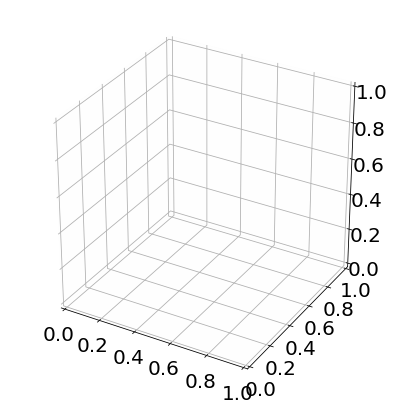

In [35]:
plt.rcParams.update({'font.size': 14})
from mpl_toolkits import mplot3d
from itertools import compress 
from tools_lnd import gen_X_from_model_dir, gen_trials_from_model_dir, get_T_inds, vanilla_run_with_h0,comp_eig_decomp
import numpy.random as npr
from tools_lnd import make_h_all
from sklearn.decomposition import PCA

lesion_cluster = 2
task_list = ['delaygo',]
color_by = 'stim'

compare_fp_lesions(m,cluster_var,lesion_cluster,task_list)

In [ ]:
cmap = plt.get_cmap('rainbow')
c_list = np.min(trial.stim_locs[:,[0,2]],axis=1)
c = cmap(c_list[t_num]/(2*np.pi))
FP_proj = np.dot(sorted_fps,D_use)

epoch = 'fix1'

trial = gen_trials_from_model_dir(m,rule_master,mode='test',noise_on = False)

T_inds = get_T_inds(trial,epoch)

_, h_full = gen_X_from_model_dir(m,trial,d = [])

h0 = h_full[:,t_num,T_inds[0]]
x_t = np.matlib.repmat(trial.x[T_inds[1],t_num,:],len(T_inds),1)

# s_set = [24,15,29]#delaygo
s_set = [3,22,24]#fdgo
color_set = ['r', 'm', 'b']
t_num = 0
f = os.path.join(m,'tf_fixed_pts_all_init',rule_master,epoch+'_'+str(t_num)+'.0.npz')
fp_struct = np.load(f)
fp_inds = np.argsort([LA.norm(s - h_tf) for s in fp_struct['xstar']])
sorted_fps = fp_struct['xstar']
eig_decomps = comp_eig_decomp(fp_struct['J_xstar'][:,:,:])

fig = plt.figure(figsize=(15,10),tight_layout=True,facecolor='white')
for si in range(len(s_set)):
    s = s_set[si]
    c = color_set[si]
    
    ax = plt.subplot(2,len(s_set),si+1+len(s_set))
    plt.plot(eig_decomps[s]['evals'].real,eig_decomps[s]['evals'].imag,'.',c=c,alpha = .5)
    plt.plot(xs, ys,':k')
    plt.plot(xs, -ys,':k')
    plt.ylim((-.5,.5))    
    plt.xlim((.3,1.3))
    
    plt.title('q value : ' + str(q_star[s]))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  
    
    n_steps = len(T_inds)
    ax = plt.subplot(2,len(s_set),si+1)
    
    plot_FP(sorted_fps, D_use.T, eig_decomps)
    
    plt.plot(FP_proj[s,0],FP_proj[s,1],'o',c=c,markerfacecolor = 'None',markersize = 20)
    
    x_t = np.matlib.repmat(trial.x[T_inds[1],t_num,:],n_steps,1)
        
#     #nonlinear system
    h_t = vanilla_run_with_h0(params, x_t, h0, hparams)
    jitter = np.dot(h_t,D_use)
    plt.plot(jitter[-1,0],jitter[-1,1],'^k',linewidth = 3,alpha = .5)
    plt.plot(jitter[:,0],jitter[:,1],'-k',linewidth = 3,alpha = .5)

#     #linear system
    h_t = h0[np.newaxis,:]
    for t in range(n_steps):
        del_h = h_t[-1,:] - fp_struct['xstar'][s,:]
        h1 = fp_struct['xstar'][s,:] + np.dot(fp_struct['J_xstar'][s,:,:],del_h)
        h_t = np.concatenate((h_t,h1[np.newaxis,:]),axis = 0)
    jitter = np.dot(h_t,D_use)
    plt.plot(jitter[0,0],jitter[0,1],'x',c = c,linewidth = 3,alpha = .5)
    plt.plot(jitter[:,0],jitter[:,1],':',c = c,linewidth = 3,alpha = .5)
    plt.plot(jitter[-1,0],jitter[-1,1],'^',c = c,linewidth = 3,alpha = .5)
    
#     ax.xticks('None')
#     ax.yticks('None')
#     
#     ax.spines['left'].set_visible(False)
#     ax.spines['bottom'].set_visible(False)
    plt.xlabel(axes_label1)
    plt.ylabel(axes_label2)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  
    plt.ylim((-7,7))    
    plt.xlim((-4,4))
    plt.title(str(si) + ' : linear approx')
#     plt.axis('off')

plt.show()

In [204]:
from scipy.spatial import distance
from numpy import linalg as LA
from tools_lnd import eigenspectrum_axes
def dst_to_h(h,sorted_fps):
    X = np.squeeze(sorted_fps).astype(np.float64)
    dst = np.zeros((np.shape(X)[0]))
    for xi in range(np.shape(X)[0]):
            dst[xi] = distance.euclidean(h, X[xi,:])
    return dst

def proximate_fp(h,fps):
    if len(fps)==1:
        proximate_fps = 0
    else:
        sorted_fps_list = np.argsort(dst_to_h(h,fps))
        proximate_fps = sorted_fps_list[0]
    return proximate_fps

In [24]:
def FP_PC_axes(ax):

    ax.set_xlabel('FP PC1',fontsize = 20)
    ax.set_ylabel('FP PC2',fontsize = 20)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 

In [186]:
def PC_axes(ax):

    ax.set_xlabel('h PC1',fontsize = 20)
    ax.set_ylabel('h PC2',fontsize = 20)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

In [206]:
lesion_cluster = 6

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitas

KeyboardInterrupt: 

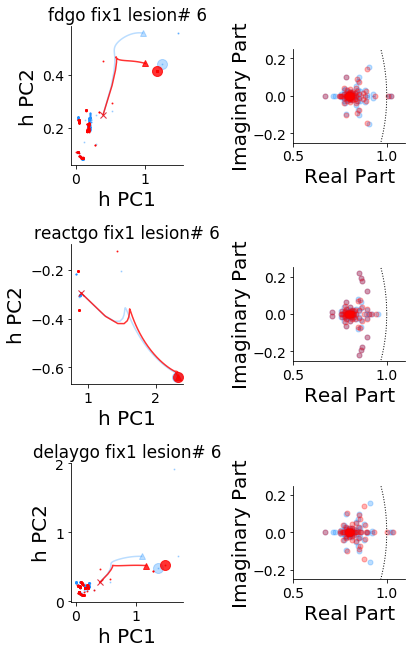

In [207]:
cmap_grad = plt.get_cmap('rainbow')
task_list = hp['rule_trains'][:-2]
n_tasks = len(task_list)
epoch = 'fix1'
ti = 0

fig = plt.figure(figsize=(3*2,3*n_tasks),tight_layout=True,facecolor='white')

for ri in range(len(task_list)):
    rule = task_list[ri]
    trial = gen_trials_from_model_dir(m,rule,noise_on = False)
    B = np.shape(trial.y_loc)[1]
    trial_set = range(0,B,int(B/10))
    
    
    T_inds = get_T_inds(trial,epoch)
    out_theta = int(180*trial.y_loc[-1,ti]/np.pi)
    
    
    
    for subplot_i in range(2):

        if subplot_i>0:
            ind_l = np.where(CA.labels == lesion_cluster)[0]
            lesion_units_list = [CA.ind_active[ind_l]][0]
            f = os.path.join(m,'lesion_fps','tf_fixed_pts_lesion'+str(lesion_cluster+1),rule,epoch+'_'+str(out_theta)+'.0.npz')
            tit_lesion = 'LESION_'+str(lesion_cluster)
            a_plot = .8
            fp_color = 'r'
        else:
            lesion_units_list = []
            f = os.path.join(m,'tf_fixed_pts_all_init',rule,epoch+'_'+str(out_theta)+'.0.npz')
            
            if not os.path.isfile(f):
                nonzero_stim = trial.stim_locs[0,:]<100
                stim_names = '_'.join(str(int(180*x/np.pi)) for x in trial.stim_locs[ti,nonzero_stim])
                filename = epoch+'_trial'+str(ti)+'_x'+stim_names+'_y'+str(out_theta)+'.npz'
                f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename)
                
            tit_lesion = 'NO_LESION'
            a_plot = .3
            fp_color = 'dodgerblue'

        fp_struct = np.load(f)
        xstar = fp_struct['xstar']
        
        _,h_all = gen_X_from_model_dir(m,trial,lesion_units_list = lesion_units_list)

        if subplot_i==0:
            D_fp = {}
            pca = PCA(n_components = n_components)
            X_flat = np.reshape(h_all[:,ti,T_inds],(-1,hp['n_rnn']))
#             X_flat = xstar
            fp_pca = pca.fit_transform(X_flat)
            D_fp['axes'] = pca.components_.T
            D_fp['labels'] = ['PCA_'+str(x+1) for x in range(n_components)]
        
            D_use = D_fp['axes']
            axes_labels = D_fp['labels']

        h_ind = h_all[:,ti,T_inds[-1]]
        proximate_fps = proximate_fp(h_ind,xstar)
        fp_num = proximate_fps
        evals, _ = LA.eig(fp_struct['J_xstar'][fp_num,:,:]) 
        
        ax1 = fig.add_subplot(n_tasks,2,1+ri*2)
        D_h = np.dot(D_use.T,h_all[:,ti,T_inds])
        plt.plot(D_h[0,:],D_h[1,:],'-',c = fp_color,alpha = a_plot)
        plt.plot(D_h[0,0],D_h[1,0],'x',c = fp_color,alpha = a_plot)
        plt.plot(D_h[0,-1],D_h[1,-1],'^',c = fp_color,alpha = a_plot)
        D_fp_all = np.dot(D_use.T,xstar.T)
        plt.plot(D_fp_all[0,:],D_fp_all[1,:],'.',c = fp_color,markersize = 2,alpha = a_plot)
        D_fp_proximal = np.dot(D_use.T,xstar[fp_num,:])
        plt.plot(D_fp_proximal[0],D_fp_proximal[1],'o',c = fp_color,markersize = 10,alpha = a_plot)
        
        ax2 = fig.add_subplot(n_tasks,2,2+ri*2)
        ax2.plot(evals.real,evals.imag,'o',c = fp_color,markersize = 5,alpha = .3)
#         ax2.plot(evals.real,evals.imag,'.',c = fp_color,alpha = .3)
    
    xs = np.linspace(-1, 1, 1000)
    ys = np.sqrt(1 - xs**2)
    ax2.plot(xs, ys,':k',linewidth = 1)
    ax2.plot(xs, -ys,':k',linewidth = 1)
    plt.xlim((.5,1.1))
    plt.ylim((-.25,.25))
#     plt.xticks(fontsize = 18)
#     plt.yticks(fontsize = 18)
    eigenspectrum_axes(epoch,ax2)
    ax2.set_aspect('equal')  
    PC_axes(ax1) 
    ax1.set_title(rule +' '+ epoch + ' lesion# '+str(lesion_cluster))
    # ax1.set_aspect('equal') 
plt.show()

In [25]:
def load_proximal_fp_from_f(f,h):
    fp_struct = np.load(f)
    xstar = fp_struct['xstar']
    
    proximate_fps = proximate_fp(h,xstar)
    fp_num = proximate_fps
    evals, _ = LA.eig(fp_struct['J_xstar'][fp_num,:,:])
    
    return xstar, fp_struct['J_xstar'], fp_num, evals

In [152]:
class rnn_obj(object):

    default_hps = {
        'tf_dtype': 'float32',
        'random_seed': model_n,
        'rnn_cell_feed_dict': {},
    }

    def __init__(self, rnn_cell, sess,
        random_seed=default_hps['random_seed'],
        tf_dtype=default_hps['tf_dtype'],
        rnn_cell_feed_dict=default_hps['rnn_cell_feed_dict']):
        
        self.rnn_cell = rnn_cell
        self.rnn_cell_feed_dict = rnn_cell_feed_dict
        self.session = sess
        self.tf_dtype = getattr(tf, tf_dtype)
        
    def _grab_RNN(self, initial_states, inputs):

        x = tf.Variable(initial_states, dtype=self.tf_dtype)
        x_rnncell = x

        inputs_tf = tf.constant(inputs, dtype=self.tf_dtype)

        output, F_rnncell = self.rnn_cell(inputs_tf, x_rnncell)
        F = F_rnncell
        
        init = tf.variables_initializer(var_list=[x,])
        self.session.run(init)

        return x, F

In [159]:
from tensorflow.python.ops import parallel_for as pfor
import absl

def calc_Jac(sess,rnn_o,feed_dict,states,inputs):
    x_tf, F_tf = rnn_o._grab_RNN(states, inputs)
    try:
       dFdx_tf = pfor.batch_jacobian(F_tf, x_tf)
    except absl.flags._exceptions.UnparsedFlagAccessError:
       dFdx_tf = pfor.batch_jacobian(F_tf, x_tf, use_pfor=False)
    dFdx_np = sess.run(dFdx_tf)
    return dFdx_np

def calc_relevant_jacobian(m,fp_struct,fp_num):
    
    model = FixedPoint_Model(m)
    with tf.Session() as sess:
        model.restore()

        rnn_o_hps = {}
        rnn_o = []
        rnn_o = rnn_obj(model.cell,sess, **rnn_o_hps) 

        state = fp_struct['xstar'][fp_num][np.newaxis,:]
        inputs = fp_struct['inputs'][fp_num][np.newaxis,:]

        dFdx = calc_Jac(sess,rnn_o,feed_dict,state,inputs)
    return dFdx

In [184]:
len([])

0

In [207]:
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster
from tools_lnd import make_dendro

lesion_cluster = 8
epoch = 'go1'
ti = 0
task_list = hparams['rule_trains']

method = 'ward'
max_d = 3
lesion_folder = 'lesion_fps_hierarchical_'+method+'_max_d'+str(max_d)
save_dir = os.path.join(m,lesion_folder)
if not os.path.isfile(save_dir) :
    make_dendro(m)
    
cluster_var = np.load(os.path.join(save_dir,'cluster_var.npz'))
D = cluster_var['D']
CA = cluster_var['CA']
clusters = cluster_var['clusters']
lesion_units_list = cluster_var['lesion_units_list']

lesion_effect[epoch] = {}

lesion_effect[epoch]['task_list'] = task_list
lesion_effect[epoch]['J_corr']= np.zeros(len(task_list))
lesion_effect[epoch]['h_corr']= np.zeros(len(task_list))
lesion_effect[epoch]['dst_h_start']= np.zeros(len(task_list))
lesion_effect[epoch]['dst_h_end']= np.zeros(len(task_list))
lesion_effect[epoch]['dst_fp']= np.zeros(len(task_list))

for ri in range(len(task_list)):
    rule = task_list[ri]
    trial = gen_trials_from_model_dir(m,rule,noise_on = False)
    
    if  epoch in trial.epochs.keys():
        
        T_inds = get_T_inds(trial,epoch)
        out_theta = int(180*trial.y_loc[-1,ti]/np.pi)

        #LESION
        lesion_units=lesion_units_list[lesion_cluster]
        f = os.path.join(m,lesion_folder,'tf_fixed_pts_lesion_'+str(lesion_cluster),rule,epoch+'_'+str(out_theta)+'.0.npz')
        
        fp_struct = np.load(f)
        
        #identify relevant fp
        _,h_all = gen_X_from_model_dir(m,trial,lesion_units_list = lesion_units)
        h_epoch_lesion = h_all[:,ti,T_inds]
        proximate_fps = proximate_fp(h_epoch_lesion[:,-1],fp_struct['xstar'])
        fp_num = proximate_fps
        xstar_lesion = fp_struct['xstar'][fp_num,:]
        J_xstar_lesion = calc_relevant_jacobian(m,fp_struct,fp_num)
        
        #NO LESION
        lesion_units = []
        f = os.path.join(m,lesion_folder,'tf_fixed_pts_lesion_'+str(0),rule,epoch+'_'+str(out_theta)+'.0.npz')
        
#         if not os.path.isfile(f):
#             nonzero_stim = trial.stim_locs[0,:]<100
#             stim_names = '_'.join(str(int(180*x/np.pi)) for x in trial.stim_locs[ti,nonzero_stim])
#             filename = epoch+'_trial'+str(ti)+'_x'+stim_names+'_y'+str(out_theta)+'.npz'
#             f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename)

        fp_struct = np.load(f)
    
        #identify relevant fp
        _,h_all = gen_X_from_model_dir(m,trial,lesion_units_list = lesion_units)
        h_epoch_full = h_all[:,ti,T_inds]
        proximate_fps = proximate_fp(h_epoch_full[:,-1],fp_struct['xstar'])
        fp_num = proximate_fps
        xstar_full = fp_struct['xstar'][fp_num,:]
        J_xstar_full = calc_relevant_jacobian(m,fp_struct,fp_num)

        #correlation of Jacobian around FP
        J_full = J_xstar_full[0]
        J_lesion = J_xstar_lesion[0]
        pearson = np.corrcoef(J_full.flatten(),J_lesion.flatten())
        lesion_effect[epoch]['J_corr'][ri] = pearson[1,0]

        #correlation of hidden state traj
        pearson = np.corrcoef(h_epoch_full.flatten(),h_epoch_lesion.flatten())
        lesion_effect[epoch]['h_corr'][ri] = pearson[1,0]

        #dist of hidden state traj
        dst_h = [LA.norm(h_epoch_full[:,x] - h_epoch_lesion[:,x]) for x in range(np.shape(h_epoch_lesion)[1])]
        lesion_effect[epoch]['dst_h_start'][ri] = dst_h[0]
        lesion_effect[epoch]['dst_h_end'][ri] = dst_h[-1]

        #dist of proximal fp
        lesion_effect[epoch]['dst_fp'][ri] = LA.norm(xstar_full - xstar_lesion)
        
    else:
        lesion_effect[epoch]['J_corr'][ri] = np.NaN
        lesion_effect[epoch]['h_corr'][ri] = np.NaN
        lesion_effect[epoch]['dst_h_start'][ri] = np.NaN
        lesion_effect[epoch]['dst_h_end'][ri] = np.NaN
        lesion_effect[epoch]['dst_fp'][ri] = np.NaN
        
# save cluster variables
lesion_effect_var = {epoch:lesion_effect[epoch]}
np.savez(os.path.join(save_dir,epoch+'_lesion_effect_var.npz'),**lesion_effect_var)
    

ImportError: cannot import name make_dendro

In [35]:

save_dir = os.path.join(figpath,'lesion '+str(lesion_cluster))
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

NameError: name 'lesion_cluster' is not defined

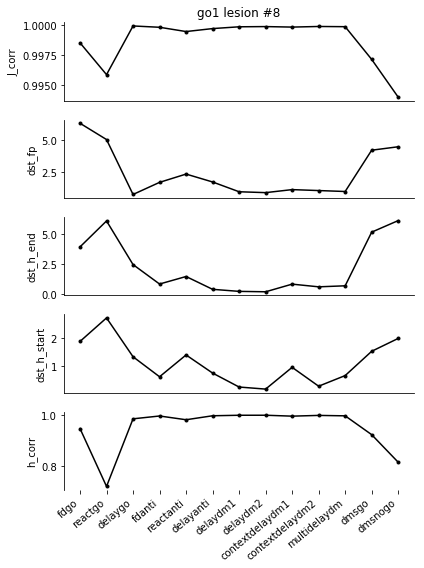

In [206]:
fig = plt.figure(figsize=(6,8),tight_layout=True,facecolor='white')
nc = len(lesion_effect[epoch].keys())-1
nr = 1

keys_list = np.sort(lesion_effect[epoch].keys())

for col_i in range(nc):
    ax1 = plt.subplot(nc,1,col_i+1)
    key = keys_list[col_i]
    plt.plot(lesion_effect[epoch][key][:-2],'.-k')
    
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    plt.ylabel(key)

    if col_i==0:
        plt.title(epoch+' lesion #'+str(lesion_cluster))
        ax1.set_xticks([])
    elif col_i==(nc-1):
        ax1.spines['bottom'].set_visible(False)
        task_list = lesion_effect[epoch]['task_list']
        ax1.set_xticks(range(len(task_list[:-2])))
        ax1.set_xticklabels(task_list[:-2],rotation = 40,ha='right')
    else:
        ax1.set_xticks([])

figname = epoch+'_fp_lesion_stats'
plt.savefig(os.path.join(save_dir,figname+'.pdf'))

In [190]:
lesion_effect[epoch]['task_list']

[u'fdgo',
 u'reactgo',
 u'delaygo',
 u'fdanti',
 u'reactanti',
 u'delayanti',
 u'delaydm1',
 u'delaydm2',
 u'contextdelaydm1',
 u'contextdelaydm2',
 u'multidelaydm',
 u'dmsgo',
 u'dmsnogo',
 u'dmcgo',
 u'dmcnogo']